In [39]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
%matplotlib inline


In [40]:
df = pd.read_csv("1976-2020-president.csv")

In [41]:
df[(df[["state_po",'year']]==["MN",2000]).all(axis=1)]

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
2210,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"GORE, AL",DEMOCRATIC-FARMER-LABOR,False,1168266,2438685,20210113,NaN,DEMOCRAT
2211,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"BUSH, GEORGE W.",REPUBLICAN,False,1109659,2438685,20210113,NaN,REPUBLICAN
2212,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"NADER, RALPH",GREEN,False,126696,2438685,20210113,NaN,OTHER
2213,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"BUCHANAN, PATRICK """"PAT""""",REFORM PARTY MINNESOTA,False,22166,2438685,20210113,NaN,OTHER
2214,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"BROWNE, HARRY",LIBERTARIAN,False,5282,2438685,20210113,NaN,LIBERTARIAN
2215,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"PHILLIPS, HOWARD",CONSTITUTION PARTY,False,3272,2438685,20210113,NaN,OTHER
2216,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"BUCHANAN, PATRICK """"PAT""""",REFORM PARTY,False,2294,2438685,20210113,NaN,OTHER
2217,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,"HARRIS, JAMES",SOCIALIST WORKERS,False,1022,2438685,20210113,NaN,OTHER
2218,2000,MINNESOTA,MN,27,41,33,US PRESIDENT,NaN,NaN,True,28,2438685,20210113,NaN,OTHER


In [42]:
df['party_simplified'] = df['party_simplified'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else '3RDPARTY')

# Step 2: Aggregate the votes for "3RDPARTY"
df_grouped = df.groupby(['year', 'state_po', 'party_simplified'], as_index=False).agg({'candidatevotes': 'sum'})

# Step 3: Pivot the table
matrix = df_grouped.pivot_table(index='state_po', columns=['party_simplified','year'], values='candidatevotes', fill_value=0)


In [43]:
prior_preds = {}

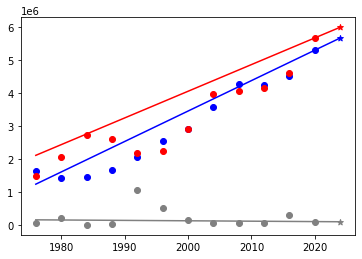

In [44]:
for i,row in matrix.iterrows():
    t = row["DEMOCRAT"].index.values
    that = np.append(t,2024)

    X3 = row["3RDPARTY"].values
    m3 = np.std(X3)/np.std(t)*np.corrcoef(X3,t)[0,1]
    b3 = X3[-1] - m3*t[-1]
    X3hats = m3*that + b3
    X3hat2024 = m3*2024 + b3
    X3var = np.sum((X3-X3hats[:-1])**2) / (len(X3) - 2)


    XD = row["DEMOCRAT"].values
    mD = np.std(XD)/np.std(t)*np.corrcoef(XD,t)[0,1]
    bD = XD[-1] - mD*t[-1]
    XDhats = mD*that + bD
    XDhat2024 = mD*2024 + bD
    XDvar = np.sum((XD-XDhats[:-1])**2) / (len(XD) - 2)

    XR = row["REPUBLICAN"].values
    mR = np.std(XR)/np.std(t)*np.corrcoef(XR,t)[0,1]
    bR = XR[-1] - mR*t[-1]
    XRhats = mR*that + bR
    XRhat2024 = mR*2024 + bR
    XRvar = np.sum((XR-XRhats[:-1])**2) / (len(XR) - 2)
    if i=="FL":
        fig,ax = plt.subplots()
        ax.scatter(t,X3,color='grey')
        ax.plot(that,X3hats,color='grey')
        ax.scatter(2024,X3hat2024,color='grey',marker='*')

        ax.scatter(t,XD,color='blue')
        ax.plot(that,XDhats,color='blue')
        ax.scatter(2024,XDhat2024,color='blue',marker='*')

        ax.scatter(t,XR,color='red')
        ax.plot(that,XRhats,color='red')
        ax.scatter(2024,XRhat2024,color='red',marker='*')

    prior_preds[row.name] = {
        "other_vote":X3hat2024,
        "other_var":X3var,
        "dem_vote" :XDhat2024,
        "dem_var": XDvar,
        "rep_vote": XRhat2024,
        "rep_var":XRvar,    }


In [45]:
prior_preds = pd.DataFrame(data=prior_preds).T

In [46]:
prior_vars_scaled = prior_preds[["other_var","dem_var","rep_var"]].copy()

prior_vars_scaled["other_var"] = prior_vars_scaled["other_var"] / prior_preds["other_vote"]**2
prior_vars_scaled["dem_var"] = prior_vars_scaled["dem_var"] / prior_preds["dem_vote"]**2
prior_vars_scaled["rep_var"] = prior_vars_scaled["rep_var"] / prior_preds["rep_vote"]**2


prior_preds_scaled = prior_preds[["other_vote","dem_vote","rep_vote"]].copy()

prior_preds_votes = prior_preds_scaled.sum(axis=1)
prior_preds_scaled=prior_preds_scaled.div(prior_preds_votes,axis=0,)
prior_preds_scaled['total_vote_pred'] = prior_preds_votes
prior_preds_scaled_normalised = prior_preds_scaled.apply(lambda col: (col - np.average(col,weights=prior_preds_scaled["total_vote_pred"])))

poll_other = 0.046
poll_dem = 0.473
poll_rep = 0.436

post_preds_scaled_normalised = prior_preds_scaled_normalised.copy()
post_preds_scaled_normalised['other_vote'] += poll_other
post_preds_scaled_normalised['dem_vote'] += poll_dem
post_preds_scaled_normalised['rep_vote'] += poll_rep

In [47]:
electoralvotes = {
    "AL":9,
    "AK":3,
    "AZ":11,
    "AR":6,
    "CA":54,
    "CO":10,
    "CT":7,
    "DC":3,
    "DE":3,
    "FL":30,
    "GA":16,
    "HI":4,
    "ID":4,
    "IL":19,
    "IN":11,
    "IA":6,
    "KS":6,
    "KY":8,
    "LA":8,
    "ME":4,
    "MD":10,
    "MA":11,
    "MI":15,
    "MN":10,
    "MS":6,
    "MO":10,
    "MT":4,
    "NE":5,
    "NV":6,
    "NH":4,
    "NJ":14,
    "NM":5,
    "NY":28,
    "NC":16,
    "ND":3,
    "OH":17,
    "OK":7,
    "OR":8,
    "PA":19,
    "RI":4,
    "SC":9,
    "SD":3,
    "TN":11,
    "TX":40,
    "UT":6,
    "VT":3,
    "VA":13,
    "WA":12,
    "WV":4,
    "WI":10,
    "WY":3}	


In [48]:
model_outputs = {}
for i,row in post_preds_scaled_normalised.iterrows():
    vars = prior_vars_scaled.loc[i]

    dem_margin_mu = row["dem_vote"] - row["rep_vote"]
    dem_margin_var = vars["dem_var"] + vars["rep_var"] + 0.08**2 # 0.08 is a one sigma polling uncertainty squared to make variance. More uncertainty from underyling fluctuations than a polling error
    z_for_dem_win = (0 - dem_margin_mu) / dem_margin_var # Zscore such that for any zscore larger the result is a democratic victory
    cdf = np.vectorize(lambda x: (1+erf(x/np.sqrt(2)))/2) # CDF for standard gaussian
    p_dem_win = 1 - cdf(z_for_dem_win) # Probability of dem winning is probability of a Zscore larger that z_for_dem_win.

    model_outputs[i] = {
        "Probability Harris Win":p_dem_win,
        "Mean Harris Margin":dem_margin_mu,
        "Harris Voteshare":row["dem_vote"],
        "Trump Voteshare":row["rep_vote"],
        "Other Voteshare":row["other_vote"],
        "Total Number of Votes":prior_preds_scaled.loc[i,"total_vote_pred"],
        "EV":electoralvotes[i]
    }
model_outputs = pd.DataFrame(data = model_outputs).T

In [49]:
EV_HARRIS_MEAN = model_outputs["EV"]*model_outputs["Probability Harris Win"]
EV_HARRIS_VAR = (model_outputs["EV"]**2) *model_outputs["Probability Harris Win"]*(1-model_outputs["Probability Harris Win"])

z_for_dem_win = (0 - EV_HARRIS_MEAN.sum()) / EV_HARRIS_VAR.sum() # Zscore such that for any zscore larger the result is a democratic victory
p_dem_win = 1 - cdf(z_for_dem_win) # Probability of dem winning is probability of a Zscore larger that z_for_dem_win.



OVERALL = pd.Series({
        "Probability Harris Win":p_dem_win,
        "Mean Harris Margin":(model_outputs["Mean Harris Margin"]*model_outputs["Total Number of Votes"]).sum(),
        "Harris Voteshare":(model_outputs["Harris Voteshare"]*model_outputs["Total Number of Votes"]).sum(),
        "Trump Voteshare":(model_outputs["Trump Voteshare"]*model_outputs["Total Number of Votes"]).sum(),
        "Other Voteshare":(model_outputs["Other Voteshare"]*model_outputs["Total Number of Votes"]).sum(),
        "Total Number of Votes":model_outputs["Total Number of Votes"].sum(),
        "EV":EV_HARRIS_MEAN.sum()
    })



In [50]:
OVERALL.round(3)

Probability Harris Win    6.700000e-01
Mean Harris Margin        6.100469e+06
Harris Voteshare          7.798707e+07
Trump Voteshare           7.188661e+07
Other Voteshare           7.584367e+06
Total Number of Votes     1.648775e+08
EV                        2.799390e+02
dtype: float64

In [51]:
model_outputs.round(3)

,Probability Harris Win,Mean Harris Margin,Harris Voteshare,Trump Voteshare,Other Voteshare,Total Number of Votes,EV
AK,0.000,-0.111,0.387,0.498,0.070,3.788441e+05,3.0
AL,0.000,-0.281,0.316,0.598,0.041,2.422341e+06,9.0
AR,0.000,-0.312,0.293,0.605,0.057,1.255938e+06,6.0
AZ,0.462,-0.007,0.453,0.459,0.043,3.599248e+06,11.0
CA,1.000,0.297,0.602,0.305,0.049,1.821759e+07,54.0
CO,0.998,0.128,0.511,0.383,0.061,3.470615e+06,10.0
CT,1.000,0.212,0.563,0.352,0.040,1.853826e+06,7.0
DC,1.000,0.865,0.884,0.019,0.052,3.588224e+05,3.0
DE,1.000,0.187,0.550,0.363,0.042,5.289974e+05,3.0
FL,0.118,-0.041,0.439,0.480,0.036,1.175533e+07,30.0


In [52]:
text = model_outputs.apply(lambda row:
                           f" <b><i>{df[['state','state_po']].set_index('state_po').to_dict()['state'][row.name]}</i> {int(row['EV'])} EV's</b> \
                           <br><i>Probability Harris Wins</i>: <b>{np.round(row['Probability Harris Win']*100,1)}%</b> \
                           <br><i>Predicted Harris Voteshare</i>: <b>{np.round(row['Harris Voteshare']*100,1)}%</b> \
                            <br><i>Predicted Trump Voteshare</i>: <b>{np.round(row['Trump Voteshare']*100,1)}%</b> \
                           <br><i>Predicted Other Voteshare</i>: <b>{np.round(row['Other Voteshare']*100,1)}%</b> \
                            ",axis=1)

In [53]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
chloropleth_cmap = [(0, republican_red),(0.5,"white"), (1, democratic_blue)]
histogram_cmap = [(0, "red"),(0.4, "red"), (0.5,"#c478b1"), (0.6, "blue"), (1, "blue")]

In [72]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=model_outputs.index, # Spatial coordinates
    z = model_outputs["Probability Harris Win"], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = chloropleth_cmap,
    # colorbar_title = "Probability Harris Win",
    text = text,
    hoverinfo="text",
    showscale=False
))

fig.update_layout(
    # title_text = f'2024 Electoral Forecast: Kamala Harris has a {OVERALL["Probability Harris Win"].round(3)*100}% chance to win the election',
    geo_scope='usa', # limite map scope to USA
    title=None,  # Remove title
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space
)

fig.write_html("./chloropleth.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [63]:
run = []

for _ in range(10000):
    harris_ev = 0
    for index,row in model_outputs.iterrows():
        p = np.random.rand()
        if p>row["Probability Harris Win"]:
            harris_ev += row["EV"]
    run.append(harris_ev)

run = np.asarray(run)

In [75]:
counts,bins = np.histogram(run,bins=260,range=(140,400))

In [88]:
text = [f"<b>Harris wins {int(bins[i])} EV's in {count} runs \
        <br> out of {sum(counts)} simulations </b>" for i,count in enumerate(counts)]

In [97]:
fig = go.Figure(data=[go.Bar(
    x=bins,
    y=counts/sum(counts)*100,
    marker={'color': bins, 'colorscale': histogram_cmap},
    text =text,    
    hoverinfo='text',
    textposition = "none"
    )])
# Add titles and labels
fig.update_layout(
    # title='Histogram of Electoral Votes',
    xaxis_title='Harris Electoral College Vote',
    # yaxis_title='Frequency',
)
fig.add_shape(
    go.layout.Shape(
        type='line',
        x0=270,
        y0=0,
        x1=270,
        y1=max(fig.data[0].y)*1.2,  # Adjust y1 to match the range of your data
        line=dict(
            color='Black',
            width=2,
            dash='dot',  # Dotted line
        ),
    )
)
fig.add_annotation(
    x=270,
    y=max(fig.data[0].y),  # Position text slightly below the top of the y-axis
    text="<b>Harris wins the election<b><br>---------->",
    showarrow=True,
    arrowhead=0,
    ax=85,  # X offset for the text
    ay=0,   # Y offset for the text
    font=dict(size=12, color="Black"),
    align='left'
)
# fig.show()
fig.write_html("./histogram.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [66]:
sum(run >= 270)

6307

In [100]:
OVERALL

Probability Harris Win    6.697651e-01
Mean Harris Margin        6.100469e+06
Harris Voteshare          7.798707e+07
Trump Voteshare           7.188661e+07
Other Voteshare           7.584367e+06
Total Number of Votes     1.648775e+08
EV                        2.799390e+02
dtype: float64